In [ ]:
!pip install segmentation-models
!pip install tta-wrapper

In [2]:
# mount drive to access the project
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
project_folder = "/content/drive/My Drive/w210_project"
%cd $project_folder

/content/drive/My Drive/w210_project


# Data generator

In [4]:
from tensorflow.keras.utils import Sequence
from skimage.io import imread
import cv2
import os
import glob
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import tensorflow as tf

#tf.logging.set_verbosity(tf.logging.ERROR)
%load_ext autoreload
%autoreload 2
%matplotlib inline
from albumentations import (Blur, Compose, HorizontalFlip, HueSaturationValue,
                            IAAEmboss, IAASharpen, JpegCompression, OneOf,
                            RandomBrightness, RandomBrightnessContrast,
                            RandomContrast, RandomCrop, RandomGamma,
                            RandomRotate90, RGBShift, ShiftScaleRotate,
                            Transpose, VerticalFlip, ElasticTransform, GridDistortion, OpticalDistortion)
 
import albumentations as albu
from albumentations import Resize

class DataGeneratorFolder(Sequence):
    def __init__(self, root_dir=r'./dataset/solar_panel/', image_folder='images/', mask_folder='masks/', 
                 batch_size=1, image_size=416, nb_y_features=1, 
                 augmentation=None,
                 suffle=True):
        self.images_folder = os.path.join(root_dir, image_folder)
        self.masks_folder = os.path.join(root_dir, mask_folder)
        self.image_filenames = os.listdir(os.path.join(root_dir, image_folder))        
        self.mask_names = os.listdir(os.path.join(root_dir, mask_folder))
        self.batch_size = batch_size
        self.currentIndex = 0
        self.augmentation = augmentation
        self.image_size = image_size
        self.nb_y_features = nb_y_features
        self.indexes = None
        self.suffle = suffle

        print(self.image_filenames)
        
    def __len__(self):
        """
        Calculates size of batch
        """
        return int(np.ceil(len(self.image_filenames) / (self.batch_size)))

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.suffle==True:
            self.image_filenames, self.mask_names = shuffle(self.image_filenames, self.mask_names)
        
    def read_image_mask(self, image_name, mask_name):
        return cv2.imread(os.path.join(self.images_folder, image_name), cv2.IMREAD_COLOR)/255, (cv2.imread(os.path.join(self.masks_folder, image_name), cv2.IMREAD_GRAYSCALE) > 0).astype(np.int8)

    def __getitem__(self, index):
        """
        Generate one batch of data
        
        """
        # Generate indexes of the batch
        data_index_min = int(index*self.batch_size)
        data_index_max = int(min((index+1)*self.batch_size, len(self.image_filenames)))
        
        indexes = self.image_filenames[data_index_min:data_index_max]

        this_batch_size = len(indexes) # The last batch can be smaller than the others
        
        # Defining dataset
        X = np.empty((this_batch_size, self.image_size, self.image_size, 3), dtype=np.float32)
        y = np.empty((this_batch_size, self.image_size, self.image_size, self.nb_y_features), dtype=np.uint8)

        for i, sample_index in enumerate(indexes):

            X_sample, y_sample = self.read_image_mask(self.image_filenames[index * self.batch_size + i], 
                                                    self.mask_names[index * self.batch_size + i])
                 
            # if augmentation is defined, we assume its a train set
            if self.augmentation is not None:
                  
                # Augmentation code
                augmented = self.augmentation(self.image_size)(image=X_sample, mask=y_sample)
                #print(augmented)
                image_augm = augmented['image']
                mask_augm = augmented['mask'].reshape(self.image_size, self.image_size, self.nb_y_features)
                X[i, ...] = np.clip(image_augm, a_min = 0, a_max=1)
                y[i, ...] = mask_augm
            
            # if augmentation isnt defined, we assume its a test set. 
            # Because test images can have different sizes we resize it to be divisable by 32
            elif self.augmentation is None and self.batch_size ==1:
                print(self.image_filenames[index * 1 + i])
                print(self.mask_names[index * 1 + i])
                X_sample, y_sample = self.read_image_mask(self.image_filenames[index * 1 + i], 
                                                      self.mask_names[index * 1 + i])
                #augmented = Resize(height=(X_sample.shape[0]//32)*32, width=(X_sample.shape[1]//32)*32)(image = X_sample, mask = y_sample)
                #X_sample, y_sample = augmented['image'], augmented['mask']

                #return X_sample.reshape(1, X_sample.shape[0], X_sample.shape[1], 3).astype(np.float32),\
                #       y_sample.reshape(1, X_sample.shape[0], X_sample.shape[1], self.nb_y_features).astype(np.uint8)
                return X_sample.reshape(1, X_sample.shape[0], X_sample.shape[1], 3).astype(np.float32),\
                       y_sample.reshape(1, X_sample.shape[0], X_sample.shape[1], self.nb_y_features).astype(np.uint8)

        return X, y

# Augmentation

['ckp4h2d2l00042a6dmutlcbd9.png', 'ckp4h5vro000b2a6dc3zhowo1.png', 'ckp4h8s0r000h2a6d9rt5qo32.png', 'ckp4hc20h000s2a6d17ejqip5.png', 'ckp4hebfi000y2a6d1sqvzvav.png', 'ckp4hgcum00112a6dtmfepng4.png', 'ckp4hocby001d2a6dmc9chdz1.png', 'ckp4hrf6w001l2a6dxu7nye9w.png', 'ckp4hukwc001t2a6d0s15x9hu.png', 'ckp4i2e6400252a6dtvoqrfyu.png', 'ckp4i3qx6002c2a6dt7xeqx2y.png', 'ckp4i48r9002f2a6duhb8r8ua.png', 'ckp4i4q9t002i2a6d0wsy6x5r.png', 'ckp4i5nb5002l2a6dsh95rtrz.png', 'ckp4i62ha002o2a6dlf3nneoy.png', 'ckp4i6j0q002r2a6d412spoio.png', 'ckp4i73vb002v2a6dbuzd2nix.png', 'ckp4i8pzw00312a6d6p5uc0s4.png', 'ckp4i9cys00352a6d6glyeq95.png', 'ckp4i9qus00382a6dmmftgc34.png', 'ckp4ibl2h003b2a6druji9tru.png', 'ckp4ic37z003e2a6d7guoqvr3.png', 'ckp4icrf2003i2a6dpar87flb.png', 'ckp4ijomi00002a6dyn6hcast.png', 'ckp4jf6sm00022a6dza19zxl1.png', 'ckp4jfje200052a6dcuowxlf6.png', 'ckp4ji3ix00092a6de3gikjpd.png', 'ckp4jo57000022a6d6p2cr2rn.png', 'ckp4jol0f00052a6dzfdzsmu3.png', 'ckp4jp5vu00082a6duznfc0x5.png', 'ckp4jpyx

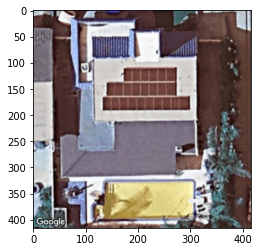

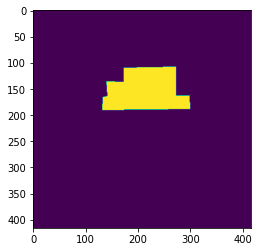

In [5]:
import numpy as np

def aug_with_crop(image_size = 416, crop_prob = 1):
    return Compose([
        RandomCrop(width = image_size, height = image_size, p=crop_prob),
        HorizontalFlip(p=0.5),
        VerticalFlip(p=0.5),
        RandomRotate90(p=0.5),
        Transpose(p=0.5),
        ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),
        RandomBrightnessContrast(p=0.5),
        RandomGamma(p=0.25),
        IAAEmboss(p=0.25),
        Blur(p=0.01, blur_limit = 3),
        OneOf([
            ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
            GridDistortion(p=0.5),
            OpticalDistortion(p=1, distort_limit=2, shift_limit=0.5)                  
        ], p=0.8)
    ], p = 1)

test_generator = DataGeneratorFolder(root_dir = './dataset/solar_panel/',
                                     image_folder = 'images/', 
                                     mask_folder = 'masks/',
                                     batch_size = 1,
                                     nb_y_features = 1, augmentation = None)
Xtest, ytest = test_generator.__getitem__(110)
plt.imshow(Xtest[0])     
plt.show()
plt.imshow(ytest[0, :,:,0])
plt.show()

In [6]:
# setting generators
test_generator = DataGeneratorFolder(root_dir = './dataset/solar_panel/', 
                           image_folder = 'images/', 
                           mask_folder = 'masks/', 
                                   batch_size=1,augmentation = aug_with_crop,
                                   nb_y_features = 1)

train_generator = DataGeneratorFolder(root_dir = 'dataset/solar_panel/', 
                                      image_folder = 'images/', 
                                      mask_folder = 'masks/', 
                                      augmentation = aug_with_crop,
                                      batch_size=4,
                                      image_size=416,
                                      nb_y_features = 1)

['ckp4h2d2l00042a6dmutlcbd9.png', 'ckp4h5vro000b2a6dc3zhowo1.png', 'ckp4h8s0r000h2a6d9rt5qo32.png', 'ckp4hc20h000s2a6d17ejqip5.png', 'ckp4hebfi000y2a6d1sqvzvav.png', 'ckp4hgcum00112a6dtmfepng4.png', 'ckp4hocby001d2a6dmc9chdz1.png', 'ckp4hrf6w001l2a6dxu7nye9w.png', 'ckp4hukwc001t2a6d0s15x9hu.png', 'ckp4i2e6400252a6dtvoqrfyu.png', 'ckp4i3qx6002c2a6dt7xeqx2y.png', 'ckp4i48r9002f2a6duhb8r8ua.png', 'ckp4i4q9t002i2a6d0wsy6x5r.png', 'ckp4i5nb5002l2a6dsh95rtrz.png', 'ckp4i62ha002o2a6dlf3nneoy.png', 'ckp4i6j0q002r2a6d412spoio.png', 'ckp4i73vb002v2a6dbuzd2nix.png', 'ckp4i8pzw00312a6d6p5uc0s4.png', 'ckp4i9cys00352a6d6glyeq95.png', 'ckp4i9qus00382a6dmmftgc34.png', 'ckp4ibl2h003b2a6druji9tru.png', 'ckp4ic37z003e2a6d7guoqvr3.png', 'ckp4icrf2003i2a6dpar87flb.png', 'ckp4ijomi00002a6dyn6hcast.png', 'ckp4jf6sm00022a6dza19zxl1.png', 'ckp4jfje200052a6dcuowxlf6.png', 'ckp4ji3ix00092a6de3gikjpd.png', 'ckp4jo57000022a6d6p2cr2rn.png', 'ckp4jol0f00052a6dzfdzsmu3.png', 'ckp4jp5vu00082a6duznfc0x5.png', 'ckp4jpyx

In [8]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard

# reduces learning rate on plateau
lr_reducer = ReduceLROnPlateau(factor=0.1,
                               cooldown= 10,
                               patience=10,verbose =1,
                               min_lr=0.1e-5)
mode_autosave = ModelCheckpoint("solarmodel.h5",monitor='val_iou_score', 
                                   mode = 'max', save_best_only=True, verbose=1, period =10)

# stop learining as metric on validatopn stop increasing
early_stopping = EarlyStopping(patience=10, verbose=1, mode = 'auto') 

# tensorboard for monitoring logs
tensorboard = TensorBoard(log_dir='./logs/tensorboard', histogram_freq=0,
                          write_graph=True, write_images=False)

callbacks = [mode_autosave, lr_reducer, tensorboard, early_stopping]

258441216/258434480 [==============================] - 5s 0us/step


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/50
28/28 [==============================] - 121s 2s/step - loss: 0.3071 - iou_score: 0.1691 - val_loss: 150.2860 - val_iou_score: 0.0615
Epoch 2/50
28/28 [==============================] - 41s 1s/step - loss: 0.1085 - iou_score: 0.3662 - val_loss: 3.6982 - val_iou_score: 0.1475
Epoch 3/50
28/28 [==============================] - 41s 1s/step - loss: 0.0784 - iou_score: 0.4732 - val_loss: 1.3651 - val_iou_score: 0.2049
Epoch 4/50
28/28 [==============================] - 40s 1s/step - loss: 0.0550 - iou_score: 0.5488 - val_loss: 0.5480 - val_iou_score: 0.3064
Epoch 5/50
28/28 [==============================] - 41s 1s/step - loss: 0.0601 - iou_score: 0.5673 - val_loss: 0.0951 - val_iou_score: 0.4986
Epoch 6/50
28/28 [==============================] - 41s 1s/step - loss: 0.0463 - iou_score: 0.6160 - val_loss: 0.0706 - val_iou_score: 0.5747
Epoch 7/50
28/28 [==============================] - 41s 1s/step - loss: 0.0535 - iou_score: 0.6077 - val_loss: 0.0855 - val_iou_score: 0.5864
Epo

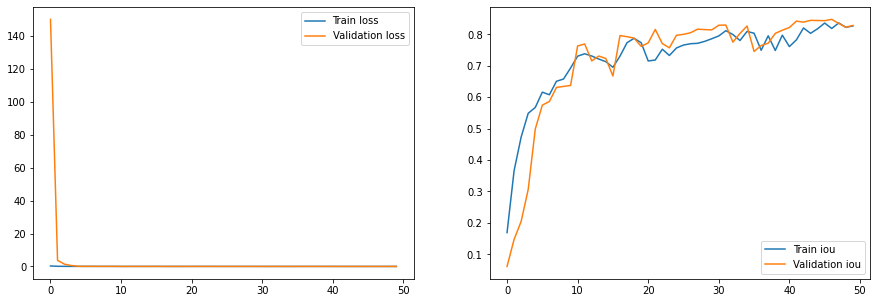

In [10]:
import segmentation_models as sm
from segmentation_models import Unet
#from keras.optimizers import Adam
from segmentation_models.losses import bce_jaccard_loss, bce_dice_loss
from segmentation_models.metrics import iou_score

def plot_training_history(history):
    """
    Plots model training history 
    """
    fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))
    ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
    ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax_loss.legend()
    ax_acc.plot(history.epoch, history.history["iou_score"], label="Train iou")
    ax_acc.plot(history.epoch, history.history["val_iou_score"], label="Validation iou")
    ax_acc.legend()
    
sm.set_framework('tf.keras')
model = Unet(backbone_name = 'efficientnetb7', encoder_weights='imagenet', encoder_freeze = False)
model.compile(optimizer = 'Adam',
                    loss='binary_crossentropy', metrics=[iou_score])

history = model.fit_generator(train_generator, shuffle =True,
                  epochs=50, workers=4, use_multiprocessing=True,
                  validation_data = test_generator, 
                  verbose = 1, callbacks=callbacks)
#plotting history
plot_training_history(history)

In [15]:
def iou_metric(y_true_in, y_pred_in):
    labels = y_true_in
    y_pred = y_pred_in

    temp1 = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=([0,0.5,1], [0,0.5, 1]))

    intersection = temp1[0]

    area_true = np.histogram(labels,bins=[0,0.5,1])[0]
    area_pred = np.histogram(y_pred, bins=[0,0.5,1])[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection
  
    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    intersection[intersection == 0] = 1e-9
    
    union = union[1:,1:]
    union[union == 0] = 1e-9

    iou = intersection / union
    return iou

def plot_mask_gt_image(mask, groud_truth, img):
    fig, axs = plt.subplots(1,3, figsize=(20,10))
    axs[0].imshow(mask, cmap="Greys")
    axs[1].imshow(groud_truth, cmap="Blues")
    axs[2].imshow(img)
    plt.show()
    
def iou_metric_batch(y_true_in, y_pred_in):
    y_pred_in = y_pred_in
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

#from tensorflow import keras
#model = keras.models.load_model('solarmodel.h5', compile=False)

# to get single image and prediction quality
Xtest, y_test  = test_generator.__getitem__(97)
predicted = model.predict(np.expand_dims(Xtest[0], axis=0)).reshape(416, 416)
print('IOU', iou_metric(y_test[0].reshape(416, 416), predicted))

IOU [[0.89037873]]


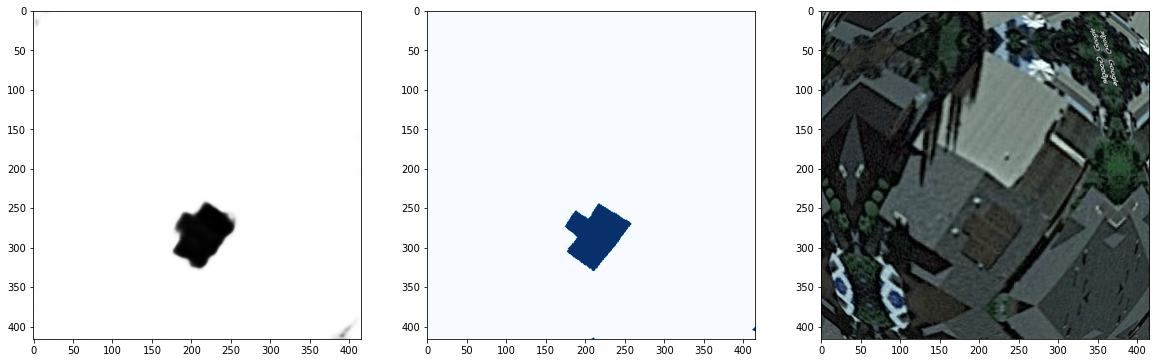

In [16]:
plot_mask_gt_image(predicted, y_test.squeeze(0).squeeze(-1),\
           Xtest.squeeze(0))

In [ ]:
scores = model.evaluate_generator(test_generator)
metrics=[iou_score]
print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1948: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


ValueError: ignored

# test time augmentation

In [ ]:
from tta_wrapper import tta_segmentation
from keras.models import load_model
model = load_model('solarmodel.h5', 
                   custom_objects={'binary_crossentropy + jaccard_loss': bce_jaccard_loss,
                                   'iou_score': iou_score})
tta_model = tta_segmentation(model, h_flip=True, merge='mean').compile(optimizer = Adam(), loss=bce_jaccard_loss, metrics=[iou_score])
scores = tta_model.evaluate_generator(test_generator)
metrics=[iou_score]
print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

AttributeError: ignored

# Adjust threshold

In [ ]:
def draw_get_best_threshold(ious, thresholds):
    """
    Returns threshold_best, iou_best
    """
    threshold_best_index = np.argmax(ious) 
    iou_best = ious[threshold_best_index]
    threshold_best = thresholds[threshold_best_index]

    plt.plot(thresholds, ious)
    plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
    plt.xlabel("Threshold")
    plt.ylabel("IoU")
    plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
    plt.legend()
    return threshold_best, iou_best

preds = []
y_val = []
for i in (range(0,test_generator.__len__())):
    Xtest, y_test  = test_generator.__getitem__(i)
    preds.append(tta_model.predict(Xtest).reshape(1472, 1472))
    y_val.append(y_test)
preds = np.stack(preds, axis=0)
y_val = np.stack(y_val, axis=0)

thresholds = list(np.linspace(0.1, 0.9, 10))
ious = np.array([iou_metric_batch(y_val, np.int32(preds > threshold)) for threshold in (thresholds)])

best_threshold, best_iou = draw_get_best_threshold(ious, thresholds)

NameError: ignored